---
# Creating RNN model to forecast daily maximum and minimum temperatures
---

In this notebook, we will try to build an RNN model that will forecast the daily variability (with seasonal variability) of maximum/minimum temperatures and its variation caused by climate change for the climate weather station located in Downtown Montreal.

I will be using as input for the model :
  - Carbon dioxide (CO2)
  - Methane (CH4)
  - Population of Montreal's
  - Previous day's maximum temperature
  - Previous day's minimum temperature
  - sin curve

The reason of the choice of the inputs parameter are the following:
  - I am hoping that the RNN model will make a link between the increase of the Greenhouse Gases (CO2 qand CH4) concentration since 1892 and the change in temperature seen in the last century caused by climate change.
  - I am hoping that the RNN model will capture the impact that the increase of population has on the land surface type (vegetation vs dense buildings), its direct impact on moisture and heat absorption, creating the Urban Heat Island Effect.
  - I need the previous day's temperature to allow the model to find the connection between the input features and the output features.


The output of the model are :
  - Maximum temperature of the day
  - Minimum temperature of the day


The model will be trained with daily data from 1892 to 2020 inclusively.

---
#### Results

The model is seeing the annual cycle of temperature well. However, it fails to see the daily variability of temperature.

I believe that adding the sin curve was a bad idea. It is forcing the data to be in this annual cycle.

---
#### Further work

Removing the sin curve forcing. 

### Loading necessary libraries

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Define files

In [4]:
#data_dir = '../data/'
data_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\data\\'
model_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\model\\'

#ghg = 'GreenHouse_Gases/processed/'
ghg = 'GreenHouse_Gases\\processed\\'

frequency = 'DLY'

climate_file = 'ECCC\\processed\\daily\\daily_processed.csv'
#climate_file = 'ECCC/processed/daily/daily_processed.csv'
#climate_file = 'ECCC/processed/monthly/monthly_processed.csv'

population_file = 'Population\\processed\\Montreal.csv'
#population_file = 'Population/processed/Montreal.csv'

co2_file = 'co2_1850-2099_SSP2_45.csv'
ch4_file = 'ch4_1850-2099_SSP2_45.csv'

scenario = 'SSP2-45'

### Define variables

**Daily**

In [7]:
Tmax = 'Max Temp (°C)'
Tmin =  'Min Temp (°C)' 
Tmean = 'Mean Temp (°C)'

cols = ['Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag',
       'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)',
       'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag',
       'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)',
       'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag',
       'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag']

**Monthly**

### Read data files

In [10]:
co2_df = pd.read_csv(os.path.join(data_dir, ghg, co2_file), index_col=0, parse_dates=True)
co2_df.drop(columns = 'Data Source', inplace=True)
co2_df

,CO2
Year,
1850-01-01,285.200000
1851-01-01,285.100000
1852-01-01,285.000000
1853-01-01,285.000000
1854-01-01,284.900000
...,...
2095-01-01,600.885986
2096-01-01,601.365967
2097-01-01,601.796997


In [11]:
ch4_df = pd.read_csv(os.path.join(data_dir, ghg, ch4_file), index_col=0, parse_dates=True)
ch4_df

,CH4
Year,
1850-01-01,791.600000
1851-01-01,792.859068
1852-01-01,794.156502
1853-01-01,795.493289
1854-01-01,796.859405
...,...
2095-01-01,1698.879883
2096-01-01,1695.429810
2097-01-01,1692.139893


In [12]:
pop_df = pd.read_csv(os.path.join(data_dir, population_file), index_col=0, parse_dates=True)
pop_df

,Population
1801-01-01,9.000000e+03
1802-01-01,9.389547e+03
1803-01-01,9.788026e+03
1804-01-01,1.019544e+04
1805-01-01,1.061293e+04
...,...
2095-01-01,2.258385e+06
2096-01-01,2.249969e+06
2097-01-01,2.240726e+06
2098-01-01,2.230707e+06


In [13]:
wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)
wx_df

C:\Users\jocl0\AppData\Local\Temp\ipykernel_17796\1851272773.py:1: DtypeWarning: Columns (5,11,13,15,17,19,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)


,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,0.0,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,NaN,NaN,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,NaN,NaN,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,NaN,NaN,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN


### Adding columns of lagged temperature features (yesterday's min/max temperature)

In [14]:
wx_df['tmin_lag1'] = wx_df[Tmin].shift(1)
wx_df['tmax_lag1'] = wx_df[Tmax].shift(1)
wx_df

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,5.6
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.1,3.9
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.2,5.0
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.3,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,-7.5,10.7
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN,-9.8,-1.6
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-4.6,3.9


### Remove incomplete start and end year of climate dataset

In [16]:
tmp = wx_df.groupby(['Year']).count()

tmp[tmp['Station'] < 365]

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Year,,,,,,,,,,,,,,,,,,,,,
1891,71,71,71,71,71,71,71,0,71,0,...,71,10,0,0,0,0,0,0,70,70
2025,86,86,86,86,86,86,86,0,86,0,...,85,1,86,0,27,0,27,0,86,86


In [17]:
start_wx = wx_df.index.min()
end_wx = wx_df.index.max()
print(type(start_wx), end_wx)

for year in [start_wx, end_wx] :

    nbr_days_year = 366 if pd.Period(year, freq='Y').is_leap_year else 365

    yr = int(year.strftime('%Y'))
    nbr_obs_year = tmp[tmp.index == yr]['Station'].values[0]

    print('*',yr, nbr_obs_year, '*')
    
    if nbr_obs_year != nbr_days_year :
        print(f'Not full year. Removing partial {yr} from dataframe')
        wx_df = wx_df[wx_df['Year'] != yr]

        start_wx = wx_df.index.min()
        end_wx = wx_df.index.max()
    else :
        print(f'Full year. Not removing {yr} from obs dataframe.')
    
wx_df

<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2025-03-27 00:00:00
* 1891 71 *
Not full year. Removing partial 1891 from dataframe
* 2025 86 *
Not full year. Removing partial 2025 from dataframe


,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Date/Time,,,,,,,,,,,,,,,,,,,,,
1892-01-01,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,1,NaN,-5.6,...,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN,-18.3,-10.6
1892-01-02,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,2,NaN,6.7,...,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.7,-5.6
1892-01-03,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,3,NaN,2.2,...,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.1,6.7
1892-01-04,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,4,NaN,-7.2,...,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.8,2.2
1892-01-05,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,5,NaN,-12.2,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.0,-7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,27,NaN,-6.1,...,0.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-13.7,-7.9
2024-12-28,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,28,NaN,-1.7,...,0.2,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-13.2,-6.1
2024-12-29,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,29,NaN,7.6,...,5.2,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-9.6,-1.7


### Put the GreenHouse Gases dataframe and population dataframe on the same frequency as the climate data

In [26]:
if frequency == 'DLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="D")
    print(new_range)
    
    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('D').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('D').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('D').interpolate()
    
elif frequency == 'MLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="ME")
    print(new_range)

    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('ME').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('ME').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('ME').interpolate()
else :
    print('Frequency is NOT monthly or daily')

DatetimeIndex(['1892-01-01', '1892-01-02', '1892-01-03', '1892-01-04',
               '1892-01-05', '1892-01-06', '1892-01-07', '1892-01-08',
               '1892-01-09', '1892-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=48578, freq='D')


In [27]:
co2_df

,CO2
1892-01-01,294.800000
1892-01-02,294.799727
1892-01-03,294.799454
1892-01-04,294.799180
1892-01-05,294.798907
...,...
2024-12-27,424.610000
2024-12-28,424.610000
2024-12-29,424.610000
2024-12-30,424.610000


In [28]:
ch4_df

,CH4
1892-01-01,859.921329
1892-01-02,859.925885
1892-01-03,859.930442
1892-01-04,859.934998
1892-01-05,859.939554
...,...
2024-12-27,1934.802141
2024-12-28,1934.802141
2024-12-29,1934.802141
2024-12-30,1934.802141


In [29]:
pop_df

,Population
1892-01-01,2.609199e+05
1892-01-02,2.609370e+05
1892-01-03,2.609540e+05
1892-01-04,2.609711e+05
1892-01-05,2.609881e+05
...,...
2024-12-27,2.200807e+06
2024-12-28,2.200807e+06
2024-12-29,2.200807e+06
2024-12-30,2.200807e+06


### Put all the data into a single dataframe

In [325]:
full_df = pd.concat([co2_df, ch4_df, pop_df, wx_df[[Tmax,Tmin]], wx_df[['tmin_lag1', 'tmax_lag1']]], axis=1)
full_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7,-18.3,-10.6
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1,-11.7,-5.6
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8,-6.1,6.7
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0,-7.8,2.2
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7,-15.0,-7.2
...,...,...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2,-13.7,-7.9
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6,-13.2,-6.1
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6,-9.6,-1.7
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3,-2.6,7.6


### Add a day of the year column and the sin curve forcing column

In [135]:
full_df['dayofyear'] = full_df.index.dayofyear
full_df['sin'] = 80 * np.sin((np.pi/(365+31)) * full_df['dayofyear']) -30
full_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7,-18.3,-10.6,1,-29.365341
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1,-11.7,-5.6,2,-28.730723
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8,-6.1,6.7,3,-28.096184
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0,-7.8,2.2,4,-27.461765
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7,-15.0,-7.2,5,-26.827506
...,...,...,...,...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2,-13.7,-7.9,362,-8.682095
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6,-13.2,-6.1,363,-9.294476
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6,-9.6,-1.7,364,-9.908161
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3,-2.6,7.6,365,-10.523110


### Separate Train/Test/Validate dataset

In [137]:
cut_year_test = 2021
cut_year_val = 2023

cut_test = pd.to_datetime(cut_year_test, format='%Y')
cut_val = pd.to_datetime(cut_year_val, format='%Y')

train_df = full_df[full_df.index < cut_test]
test_df = full_df[(full_df.index >= cut_test) & (full_df.index < cut_val)]

In [139]:
test_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin
2021-01-01,416.410000,1894.800000,1.762949e+06,-0.2,-5.1,-6.9,3.7,1,-29.365341
2021-01-02,416.415808,1894.844164,1.763361e+06,-0.6,-5.3,-5.1,-0.2,2,-28.730723
2021-01-03,416.421616,1894.888329,1.763773e+06,-0.6,-3.5,-5.3,-0.6,3,-28.096184
2021-01-04,416.427425,1894.932493,1.764185e+06,-1.1,-3.4,-3.5,-0.6,4,-27.461765
2021-01-05,416.433233,1894.976658,1.764598e+06,-2.5,-3.6,-3.4,-1.1,5,-26.827506
...,...,...,...,...,...,...,...,...,...
2022-12-27,421.045068,1921.552329,2.100692e+06,-4.2,-8.7,-8.9,-3.3,361,-8.071055
2022-12-28,421.052055,1921.581863,2.101212e+06,0.2,-4.2,-8.7,-4.2,362,-8.682095
2022-12-29,421.059041,1921.611397,2.101732e+06,6.4,-0.6,-4.2,0.2,363,-9.294476
2022-12-30,421.066027,1921.640932,2.102253e+06,9.8,5.1,-0.6,6.4,364,-9.908161


In [141]:
train_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7,-18.3,-10.6,1,-29.365341
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1,-11.7,-5.6,2,-28.730723
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8,-6.1,6.7,3,-28.096184
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0,-7.8,2.2,4,-27.461765
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7,-15.0,-7.2,5,-26.827506
...,...,...,...,...,...,...,...,...,...
2020-12-27,416.379945,1894.580328,1.761731e+06,-2.7,-8.7,-8.1,-0.3,362,-8.682095
2020-12-28,416.385956,1894.624262,1.761975e+06,4.7,-2.7,-8.7,-2.7,363,-9.294476
2020-12-29,416.391967,1894.668197,1.762218e+06,-2.2,-8.8,-2.7,4.7,364,-9.908161
2020-12-30,416.397978,1894.712131,1.762462e+06,0.8,-7.3,-8.8,-2.2,365,-10.523110


### Separate RNN input and output data

In [143]:
cols_in = ['CH4', 'CO2', 'Population', 'tmin_lag1', 'tmax_lag1', 'sin']
cols_out = [Tmax, Tmin]

X_train = train_df[cols_in]
X_test = test_df[cols_in]

Y_train = train_df[cols_out]
Y_test = test_df[cols_out]

In [145]:
X_test

,CH4,CO2,Population,tmin_lag1,tmax_lag1,sin
2021-01-01,1894.800000,416.410000,1.762949e+06,-6.9,3.7,-29.365341
2021-01-02,1894.844164,416.415808,1.763361e+06,-5.1,-0.2,-28.730723
2021-01-03,1894.888329,416.421616,1.763773e+06,-5.3,-0.6,-28.096184
2021-01-04,1894.932493,416.427425,1.764185e+06,-3.5,-0.6,-27.461765
2021-01-05,1894.976658,416.433233,1.764598e+06,-3.4,-1.1,-26.827506
...,...,...,...,...,...,...
2022-12-27,1921.552329,421.045068,2.100692e+06,-8.9,-3.3,-8.071055
2022-12-28,1921.581863,421.052055,2.101212e+06,-8.7,-4.2,-8.682095
2022-12-29,1921.611397,421.059041,2.101732e+06,-4.2,0.2,-9.294476
2022-12-30,1921.640932,421.066027,2.102253e+06,-0.6,6.4,-9.908161


### Scale the dataset

In [147]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled_train = scaler_x.fit_transform(X_train)
X_scaled_test = scaler_x.transform(X_test)

Y_scaled_train = scaler_y.fit_transform(Y_train)
Y_scaled_test = scaler_y.transform(Y_test)

### TimeSeries Generator

In [153]:
window_size = 31

ts_generator = TimeseriesGenerator(X_scaled_train, 
                                   Y_scaled_train,
                                   length=window_size,
                                   batch_size=64)

test_generator = TimeseriesGenerator(X_scaled_test, 
                                   Y_scaled_test,
                                   length=window_size,
                                   batch_size=8)
ts_generator[0]

(array([[[0.00000000e+00, 8.21665754e-04, 0.00000000e+00, 2.62184874e-01,
          2.79389313e-01, 0.00000000e+00],
         [4.40288378e-06, 8.19420766e-04, 1.13552697e-05, 3.73109244e-01,
          3.55725191e-01, 7.99616772e-03],
         [8.80576755e-06, 8.17175778e-04, 2.27105395e-05, 4.67226891e-01,
          5.43511450e-01, 1.59913289e-02],
         ...,
         [1.23280746e-04, 7.58806079e-04, 3.17947553e-04, 3.27731092e-01,
          3.64885496e-01, 2.21868815e-01],
         [1.27683629e-04, 7.56561091e-04, 3.29302823e-04, 4.11764706e-01,
          3.64885496e-01, 2.29647551e-01],
         [1.32086513e-04, 7.54316102e-04, 3.40658092e-04, 4.11764706e-01,
          3.31297710e-01, 2.37411330e-01]],
 
        [[4.40288378e-06, 8.19420766e-04, 1.13552697e-05, 3.73109244e-01,
          3.55725191e-01, 7.99616772e-03],
         [8.80576755e-06, 8.17175778e-04, 2.27105395e-05, 4.67226891e-01,
          5.43511450e-01, 1.59913289e-02],
         [1.32086513e-05, 8.14930789e-04, 3.406

### Build RNN model

In [155]:
print(X_scaled_train.shape[0], X_scaled_train.shape[1])
print(Y_scaled_train.shape[1])

47117 6
2


In [157]:
rnn = Sequential()

rnn.add(LSTM(1024, activation='relu', return_sequences=False, input_shape=((window_size, X_scaled_train.shape[1]))))
#rnn.add(Dropout(rate= 0.1))

#rnn.add(LSTM(256, activation='relu',  return_sequences=True))
#rnn.add(Dropout(rate= 0.1))

#rnn.add(GRU(128, activation='relu', return_sequences=False, input_shape=((window_size, X_scaled_train.shape[1]))))
#rnn.add(LSTM(256, activation='relu', return_sequences=True))
#rnn.add(Dropout(rate= 0.1))

#rnn.add(LSTM(256, activation='relu', return_sequences=False))
#rnn.add(GRU(256, activation='relu', return_sequences=False))

rnn.add(Dense(Y_scaled_train.shape[1]))

rnn.compile(optimizer='adam', loss='mse')
#rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [159]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1024)              4222976   
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 4,225,026
Trainable params: 4,225,026
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [193]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
rnn.fit(ts_generator, epochs=50)
#rnn.fit(ts_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/50
736/736 [==============================] - 315s 429ms/step - loss: 0.0053
Epoch 2/50
736/736 [==============================] - 340s 462ms/step - loss: 0.0053
Epoch 3/50
736/736 [==============================] - 392s 533ms/step - loss: 0.0053
Epoch 4/50
736/736 [==============================] - 340s 461ms/step - loss: 0.0053
Epoch 5/50
736/736 [==============================] - 368s 500ms/step - loss: 0.0053
Epoch 6/50
736/736 [==============================] - 335s 456ms/step - loss: 0.0053
Epoch 7/50
736/736 [==============================] - 329s 447ms/step - loss: 0.0053
Epoch 8/50
736/736 [==============================] - 332s 451ms/step - loss: 0.0053
Epoch 9/50
736/736 [==============================] - 331s 450ms/step - loss: 0.0053
Epoch 10/50
736/736 [==============================] - 335s 456ms/step - loss: 0.0053
Epoch 11/50
736/736 [==============================] - 313s 424ms/step - loss: 0.0053
Epoch 12/50
736/736 [==============================] - 310s 422

### Save model and scalers

In [250]:
rnn.save(os.path.join(model_dir, 'rnn_months_sin_1month_1024k_more.keras'))

In [253]:
joblib.dump(scaler_x, os.path.join(model_dir, 'scaler_x.joblib'))
joblib.dump(scaler_y, os.path.join(model_dir, 'scaler_y.joblib'))

['C:\\Users\\jocl0\\ABF\\Final_Project-main\\model\\scaler_y.joblib']

### Evaluate the model on the testing dataset

In [329]:
rnn_prediction_test = []

print(window_size)
n_steps = 365 * 2

n_features = X_scaled_train.shape[1]

current_data = X_scaled_train[-(window_size):] 
current_data = current_data.reshape(1, window_size, n_features)

for i in range(n_steps): 
    
    # Prediction for t = i
    current_prediction = rnn.predict(current_data)[0]
    
    # Append it to our list of prediction
    rnn_prediction_test.append(current_prediction)

    # Retrieve X for next iteration
    next_input_step = X_scaled_test[i].copy()  

    # Replaced the 'tmin_lag1' 'tmax_lag1' by the predicted value for the next iteration
    next_input_step[3] = current_prediction[1]
    next_input_step[4] = current_prediction[0]

    # Reshape the array
    next_input_step = next_input_step.reshape(1, 1, n_features)
    
    # Removed first row of current_data and append next_input_step to current_data
    current_data = np.append(current_data[:,1:,:], next_input_step, axis=1)
    
rnn_prediction_test

31
1/1 [==============================] - 0s 69ms/step


[array([0.43415684, 0.4539112 ], dtype=float32),
 array([0.4016692, 0.4117471], dtype=float32),
 array([0.406686  , 0.42237726], dtype=float32),
 array([0.4061242 , 0.42269784], dtype=float32),
 array([0.4057988 , 0.42218453], dtype=float32),
 array([0.40367833, 0.41910842], dtype=float32),
 array([0.40035754, 0.41472116], dtype=float32),
 array([0.39580292, 0.40865436], dtype=float32),
 array([0.39153227, 0.40289742], dtype=float32),
 array([0.38803485, 0.39801943], dtype=float32),
 array([0.38518226, 0.39395955], dtype=float32),
 array([0.38286924, 0.3905401 ], dtype=float32),
 array([0.380807  , 0.38748682], dtype=float32),
 array([0.3791421 , 0.38489816], dtype=float32),
 array([0.37757576, 0.38251472], dtype=float32),
 array([0.37631896, 0.38049   ], dtype=float32),
 array([0.37540585, 0.3789212 ], dtype=float32),
 array([0.37498063, 0.37790713], dtype=float32),
 array([0.37459475, 0.37686437], dtype=float32),
 array([0.37424082, 0.37586278], dtype=float32),
 array([0.3741814, 0.3

### Inversing prediction

In [289]:
inversed_preds_test = scaler_y.inverse_transform(rnn_prediction_test)

cols_out_new = (pd.Series(cols_out) + 'model').tolist()

pred_test_df = pd.DataFrame(inversed_preds_test, columns=cols_out_new)

pred_test_df.index = test_df.iloc[:n_steps].index

full_pred_test_df = pd.concat([test_df.iloc[:n_steps], pred_test_df], axis=1)

full_pred_test_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin,Max Temp (°C)model,Min Temp (°C)model
2021-01-01,416.410000,1894.800000,1.762949e+06,-0.2,-5.1,-6.9,3.7,1,-29.365341,-0.462727,-6.892284
2021-01-02,416.415808,1894.844164,1.763361e+06,-0.6,-5.3,-5.1,-0.2,2,-28.730723,-2.590667,-9.401048
2021-01-03,416.421616,1894.888329,1.763773e+06,-0.6,-3.5,-5.3,-0.6,3,-28.096184,-2.262066,-8.768553
2021-01-04,416.427425,1894.932493,1.764185e+06,-1.1,-3.4,-3.5,-0.6,4,-27.461765,-2.298865,-8.749478
2021-01-05,416.433233,1894.976658,1.764598e+06,-2.5,-3.6,-3.4,-1.1,5,-26.827506,-2.320179,-8.780021
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,421.045068,1921.552329,2.100692e+06,-4.2,-8.7,-8.9,-3.3,361,-8.071055,-1.254292,-7.329054
2022-12-28,421.052055,1921.581863,2.101212e+06,0.2,-4.2,-8.7,-4.2,362,-8.682095,-1.377615,-7.462418
2022-12-29,421.059041,1921.611397,2.101732e+06,6.4,-0.6,-4.2,0.2,363,-9.294476,-1.503298,-7.599502
2022-12-30,421.066027,1921.640932,2.102253e+06,9.8,5.1,-0.6,6.4,364,-9.908161,-1.632374,-7.741158


### Evaluating model's prediction accuracy 
typo here the print should write MSE and not RMSE

In [291]:
print(f"Test RMSE: {np.sqrt(mean_squared_error(full_pred_test_df[Tmax],full_pred_test_df[cols_out_new[0]]))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(full_pred_test_df[Tmin],full_pred_test_df[cols_out_new[1]]))}")

Test RMSE: 4.971825483388467
Test RMSE: 4.478498996466048


<Axes: >

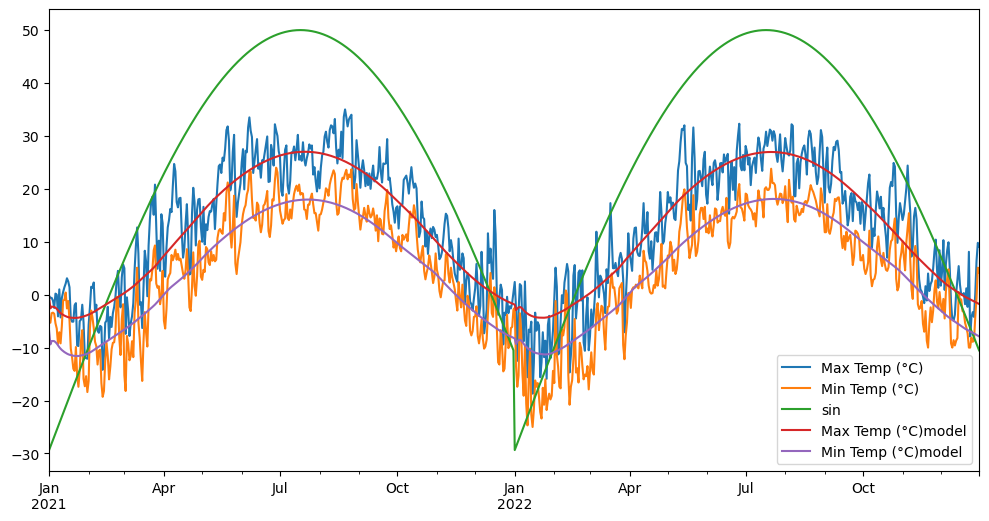

In [293]:
tmp = full_pred_test_df.drop(columns=['CO2', 'CH4', 'Population', 'tmin_lag1',	'tmax_lag1'])
#tmp['sin'] = 80 * np.sin((np.pi/(365+31)) * tmp['dayofyear']) -30
tmp = tmp.drop(columns=['dayofyear']) 
tmp.plot(figsize=(12,6))

<Axes: >

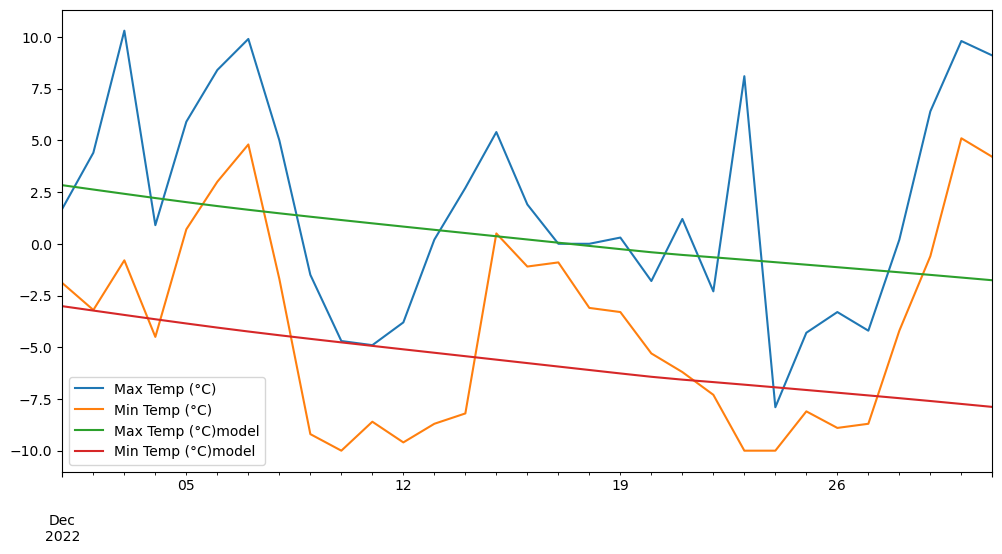

In [295]:
full_pred_test_df.drop(columns=['CO2', 'CH4', 'Population', 'tmin_lag1',	'tmax_lag1', 'dayofyear', 'sin']).iloc[-31:].plot(figsize=(12,6))